## Importing libs


In [72]:
import os
import random
import torch
import numpy as np
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import torch.nn.functional as F
from IPython.display import Image
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import torchvision.datasets as datasets
import torchvision.transforms as transforms


### Calling Transform for the dataset

In [18]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)


### Creating train and test loader

In [19]:
from torch.utils.data import random_split


# Define the sizes for train and test sets
train_size = int(0.8 * len(train_dataset))  # 80% for training
test_size = len(train_dataset) - train_size  # 20% for testing

# Split the dataset
train_set, test_set = random_split(train_dataset, [train_size, test_size])

# Create DataLoader for training and testing
train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)


In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Definition of the Model.
### Containing Res , Dec, Enc , VQ blocks according to the paper

In [21]:
# referenced to GitHub ► https://github.com/gordicaleksa
# https://colab.research.google.com/github/zalandoresearch/pytorch-vq-vae/blob/master/vq-vae.ipynb#scrollTo=6sckDjEd_Wdk

class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.embedding = nn.Embedding(self.num_embeddings, self.embedding_dim)
        self.embedding.weight.data.uniform_(-1/self.num_embeddings, 1/self.num_embeddings)
        self.commitment_cost = commitment_cost

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        # print(f"input shape : {inputs.shape}")
        inputs = inputs.permute(0, 2, 3, 1)
        input_shape = inputs.shape

        # Flatten input
        # print(f"input shape : {inputs.shape}")
        flat_input = inputs.reshape(-1, self.embedding_dim)

        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True)
                    + torch.sum(self.embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self.embedding.weight.t()))

        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self.num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)

        # Quantize and unflatten
        quantized = torch.matmul(encodings, self.embedding.weight).view(input_shape)

        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self.commitment_cost * e_latent_loss

        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)

        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2), encodings

In [6]:
class Residual(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_hiddens):
        super(Residual, self).__init__()
        self._block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(in_channels=in_channels,out_channels=num_residual_hiddens,kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(in_channels=num_residual_hiddens,out_channels=num_hiddens,kernel_size=1, stride=1, bias=False)
        )
    def forward(self, x):
        return x + self._block(x)


class ResidualStack(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(ResidualStack, self).__init__()
        self.num_residual_layers = num_residual_layers
        self._layers = nn.ModuleList([Residual(in_channels, num_hiddens, num_residual_hiddens)
                             for _ in range(self.num_residual_layers)])
    def forward(self, x):
        for i in range(self.num_residual_layers):
            x = self._layers[i](x)
        return F.relu(x)

In [7]:
class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Encoder, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels=in_channels,out_channels=num_hiddens//2,kernel_size=4,stride=2, padding=1)
        self.conv_2 = nn.Conv2d(in_channels=num_hiddens//2,out_channels=num_hiddens,kernel_size=4,stride=2, padding=1)
        self.conv_3 = nn.Conv2d(in_channels=num_hiddens,out_channels=num_hiddens,kernel_size=3,stride=1, padding=1)
        self.residual_stack = ResidualStack(in_channels=num_hiddens,num_hiddens=num_hiddens,num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)

    def forward(self, inputs):
        x = self.conv_1(inputs)
        x = F.relu(x)
        x = self.conv_2(x)
        x = F.relu(x)
        x = self.conv_3(x)
        return self.residual_stack(x)

In [8]:
class Decoder(nn.Module):
    def __init__(self ,out_channel ,in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Decoder, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels=in_channels,out_channels=num_hiddens,kernel_size=3,stride=1, padding=1)
        self.residual_stack = ResidualStack(in_channels=num_hiddens,num_hiddens=num_hiddens,num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)
        self.conv_trans_1 = nn.ConvTranspose2d(in_channels=num_hiddens,out_channels=num_hiddens//2,kernel_size=4,stride=2, padding=1)
        self.conv_trans_2 = nn.ConvTranspose2d(in_channels=num_hiddens//2,out_channels=out_channel,kernel_size=4,stride=2, padding=1)

    def forward(self, inputs):
        x = self.conv_1(inputs)
        x = self.residual_stack(x)
        x = self.conv_trans_1(x)
        x = F.relu(x)
        return self.conv_trans_2(x)

### Calling all classes to build the main Model class.

In [75]:
class Model(nn.Module):
    def __init__(self,input_channel ,num_embeddings , embedding_dim ,num_hiddens= 128, num_residual_layers= 2, num_residual_hiddens=32,commitment_cost=0.25):
        super(Model, self).__init__()
        self.encoder = Encoder(input_channel, num_hiddens,num_residual_layers,num_residual_hiddens)
        self.pre_vq_conv = nn.Conv2d(in_channels=num_hiddens,out_channels=embedding_dim,kernel_size=1,stride=1)
        self.vq_vae = VectorQuantizer(num_embeddings, embedding_dim,commitment_cost)
        self.decoder = Decoder(input_channel,embedding_dim,num_hiddens,num_residual_layers,num_residual_hiddens)

    def forward(self, x):
        z = self.encoder(x)
        z = self.pre_vq_conv(z)
        loss, quantized, _ = self.vq_vae(z)
        x_recon = self.decoder(quantized)
        return loss, x_recon


In [44]:
learning_rate  = 2e-4


### Function for showing imgs

In [12]:
def show(img,comment):
  img = img.numpy()
  fig = plt.imshow(np.transpose(img, (1,2,0)))
  plt.suptitle(comment)
  plt.tight_layout()
  fig.axes.get_xaxis().set_visible(False)
  fig.axes.get_yaxis().set_visible(False)
  plt.show()

### The main Training function which will be used then.

In [76]:
def train_vqvae_model(model ,trainloader ,num_iter= 1000):

  optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)

  model.train()
  train_loss = []
  coodbook_history = []

  for i in range(num_iter):
      total_loss = 0
      (img_batch, _) = next(iter(trainloader))
      img_batch = img_batch.to(device)
      optimizer.zero_grad()
      vq_loss, data_recon = model(img_batch)
      recon_error = F.mse_loss(data_recon, img_batch)
      loss = recon_error + vq_loss
      loss.backward()
      optimizer.step()
      coodbook_history.append(model.vq_vae.embedding.weight.data.cpu())
      train_loss.append(recon_error.item())
      if (i+1) % 100 == 0:
        print('%d Iter' % (i+1))
        print(f"Final_error: {np.mean(train_loss[-100:]):.5f}")
        print()

  return train_loss , coodbook_history



### Function for Evaluation of Model.

In [59]:
def Evaluation(model ,train_loss ,test_loader):
    plt.plot(train_loss)
    plt.title(f'train loss of VQ-VAE model')
    plt.xlabel('iters')
    plt.ylabel('total loss')
    plt.show()

    model.eval()
    test_origins, _ = next(iter(test_loader))
    test_origins = test_origins.to(device)

    vq_output_eval = model.pre_vq_conv(model.encoder(test_origins))
    _ , test_quantize, _ = model.vq_vae(vq_output_eval)
    test_recons = model.decoder(test_quantize)

    print("\n")
    show(make_grid(test_recons.cpu()),"Recon")
    print("\n")
    show(make_grid(test_origins.cpu()),"Orig")
    print("\n")
    buff = test_quantize.view(-1,7,7)
    show(make_grid(buff.unsqueeze(1).cpu().data),"Q_vecs")

### Training for 3_2D embeddings

In [77]:
input_channel = 1
num_hiddens = 128
num_residual_hiddens = 32
num_residual_layers = 2
embedding_dim = 2
num_embeddings = 3
commitment_cost = 0.25

model_3_2 = Model(input_channel ,num_embeddings , embedding_dim ,num_hiddens= 128, num_residual_layers= 2, num_residual_hiddens=32,commitment_cost=0.25).to(device)

loss_list , codeBook_list = train_vqvae_model(model_3_2, trainloader= train_loader)

100 Iter
Final_error: 0.06672

200 Iter
Final_error: 0.03090

300 Iter
Final_error: 0.02318

400 Iter
Final_error: 0.02104

500 Iter
Final_error: 0.01929

600 Iter
Final_error: 0.01780

700 Iter
Final_error: 0.01668

800 Iter
Final_error: 0.01607

900 Iter
Final_error: 0.01553

1000 Iter
Final_error: 0.01525



### Evaluation

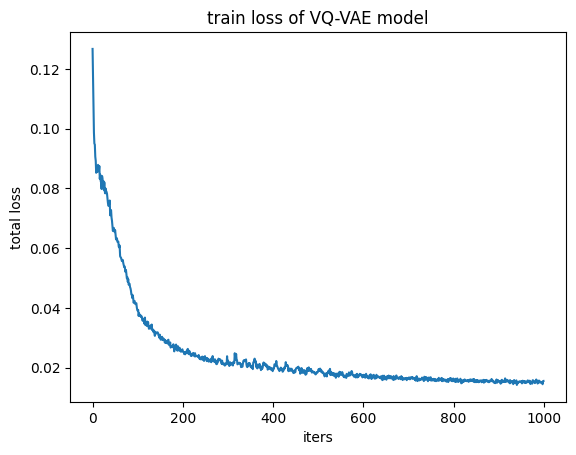

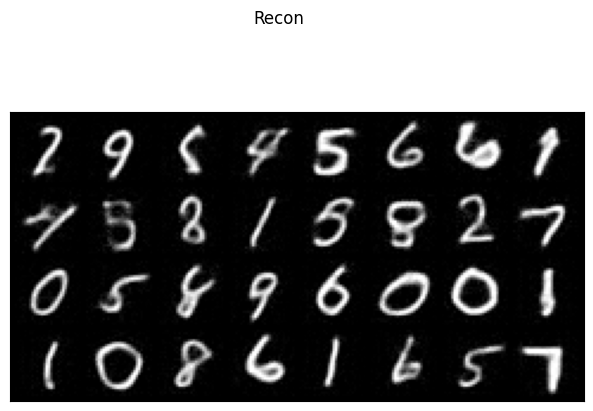

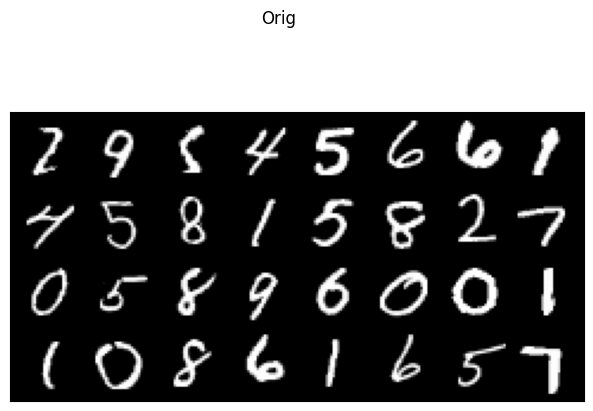

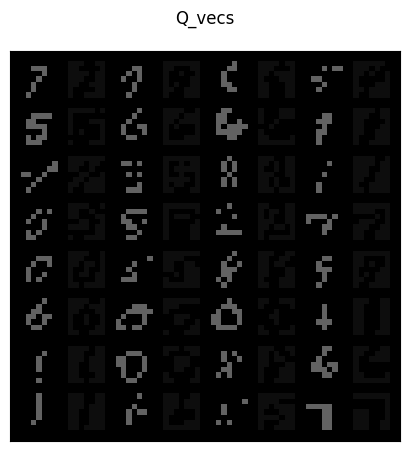

In [78]:
Evaluation(model_3_2,train_loss= loss_list ,test_loader= test_loader)

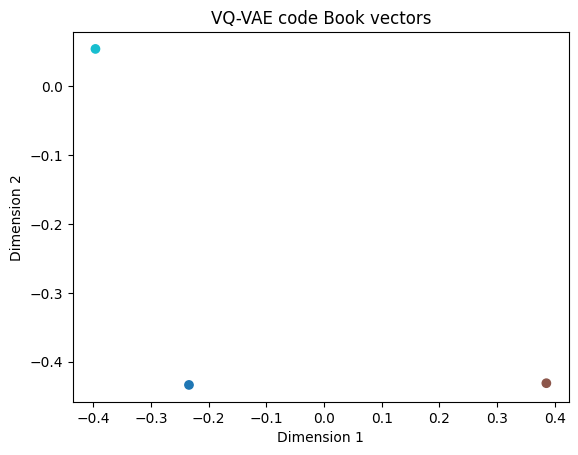

In [79]:
def visualize_codebook(model):

    buffer = model.vq_vae.embedding.weight.data.cpu()
    plt.scatter(buffer[:, 0], buffer[:, 1], c=[1,2,3], cmap="tab10")
    plt.title("VQ-VAE code Book vectors")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.show()

visualize_codebook(model_3_2)

### We are asked to produce the gif file of generated codebook

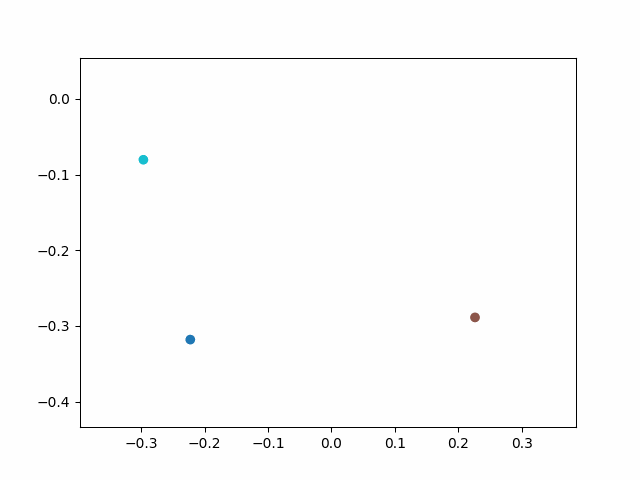

In [81]:
from IPython.display import display, Image

gif_file_path = '/content/codebook_vectors.gif'

def save_codebook_visualizations(codebooks, images):
    max_x, max_y = torch.max(torch.max(codebooks, 0)[0], 0)[0]
    min_x, min_y = torch.min(torch.min(codebooks, 0)[0], 0)[0]

    for idx, codebook in enumerate(codebooks):
        fig, ax = plt.subplots()
        ax.set_xlim(min_x, max_x)
        ax.set_ylim(min_y, max_y)
        ax.scatter(codebook[:, 0], codebook[:, 1], c=[1, 2, 3], cmap="tab10")
        plt.xticks()
        image_filename = f'./codebook_visualization_{idx}.png'
        plt.savefig(image_filename)
        plt.close(fig)
        images.append(imageio.imread(image_filename))
        os.remove(image_filename)

    return images

stacked_codebooks = torch.stack(codeBook_list)
visualization_images = []
visualization_images = save_codebook_visualizations(stacked_codebooks, visualization_images)

imageio.mimsave(gif_file_path, visualization_images, duration=0.00001)

# Display the GIF
display(Image(filename=gif_file_path, format="png"))


In [63]:
import random
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

def convert_to_rgb(image, label):
    image = image.repeat(3, 1, 1)

    for i in range(3):
        image[i, :, :] *= random.random()

    return image

colored_train_dataset = [(convert_to_rgb(img, label), label) for img, label in train_set]
colored_test_dataset = [(convert_to_rgb(img, label), label) for img, label in test_set]

batch_size = 64
train_colored_loader = DataLoader(colored_train_dataset, batch_size=batch_size, shuffle=True)
test_colored_loader = DataLoader(colored_test_dataset, batch_size=32, shuffle=True)


### Showing Colorized numbers

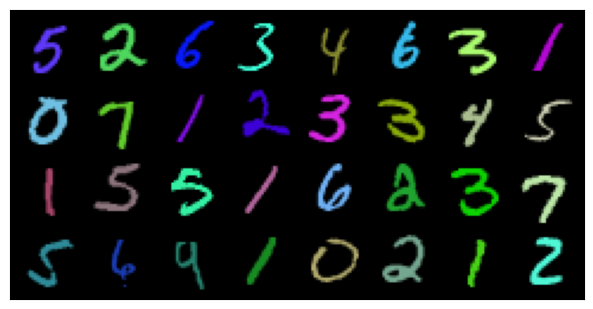

In [50]:
test_origins, _ = next(iter(test_colored_loader))
test_origins = test_origins.to(device)
show(make_grid(test_origins.cpu()),"")

### Now for 50_2D embeddings

In [64]:
input_channel = 3
num_hiddens = 128
num_residual_hiddens = 32
num_residual_layers = 2
embedding_dim = 2
num_embeddings = 50
commitment_cost = 0.25
model_50_2 = Model(input_channel ,num_embeddings , embedding_dim ,num_hiddens= 128, num_residual_layers= 2, num_residual_hiddens=32,commitment_cost=0.25).to(device)

loss_list , codeBook_list = train_vqvae_model(model_50_2,trainloader= train_colored_loader)

100 Iter
Final_error: 0.02709

200 Iter
Final_error: 0.01841

300 Iter
Final_error: 0.01472

400 Iter
Final_error: 0.01243

500 Iter
Final_error: 0.01102

600 Iter
Final_error: 0.01009

700 Iter
Final_error: 0.00853

800 Iter
Final_error: 0.00633

900 Iter
Final_error: 0.00545

1000 Iter
Final_error: 0.00493



### Evaluation

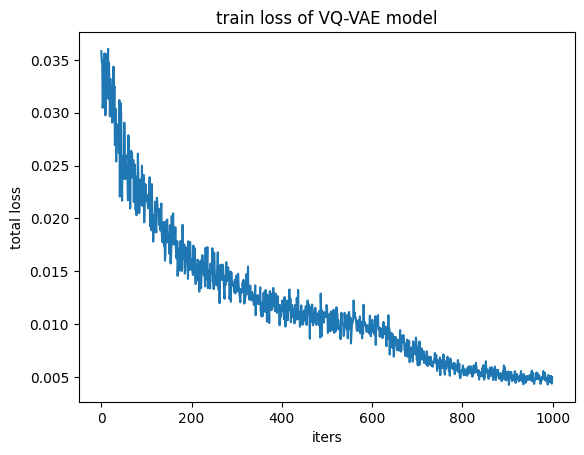

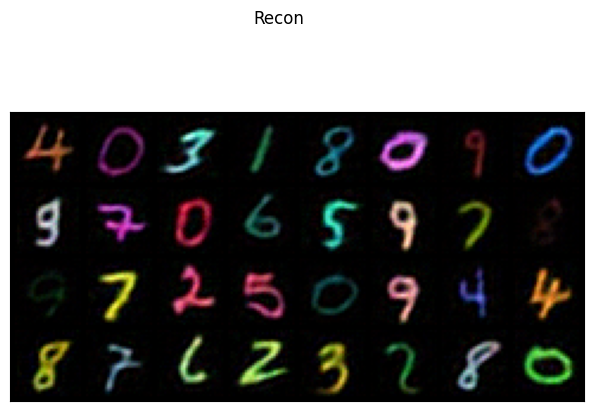

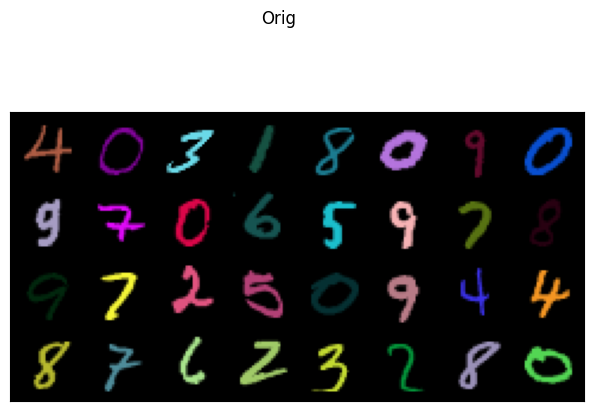

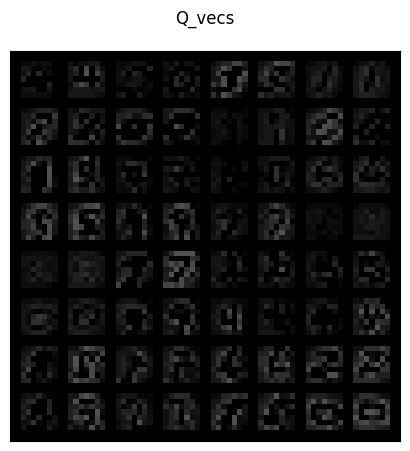

In [65]:
Evaluation(model_50_2,train_loss= loss_list ,test_loader= test_colored_loader)

### 50D in 3 embeddings

In [66]:
model_3_50 = Model(input_channel= 3,num_embeddings=3, embedding_dim=50).to(device)

loss_list , codeBook_list = train_vqvae_model(model_3_50,trainloader= train_colored_loader)

100 Iter
Final_error: 0.03109

200 Iter
Final_error: 0.02284

300 Iter
Final_error: 0.01751

400 Iter
Final_error: 0.01645

500 Iter
Final_error: 0.01552

600 Iter
Final_error: 0.01519

700 Iter
Final_error: 0.01482

800 Iter
Final_error: 0.01281

900 Iter
Final_error: 0.01214

1000 Iter
Final_error: 0.01173



### Evaluation

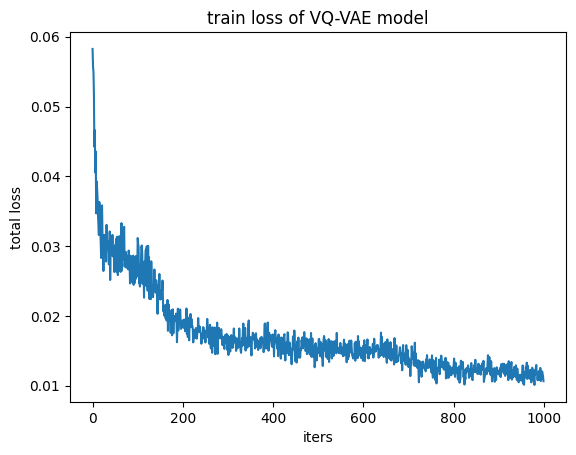

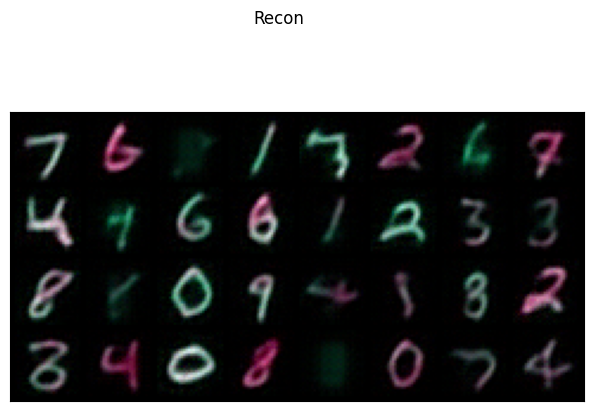

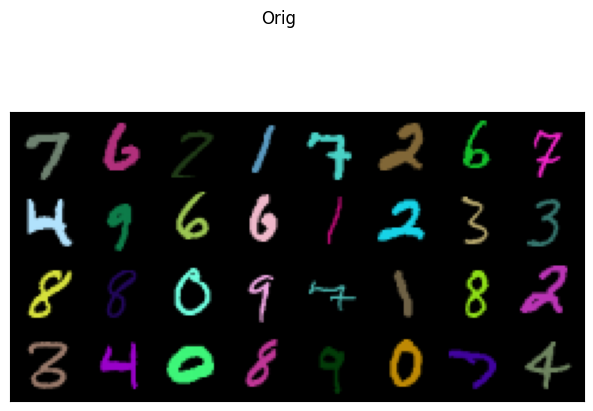

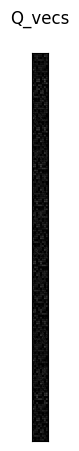

In [67]:
Evaluation(model_3_50,train_loss= loss_list  ,test_loader= test_colored_loader)

### As it seems Increasing the dimension of embeding does not have proper effect on the final results.
### The previous results seemed to be better.